In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for BoW and TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Gensim for Word2Vec
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
print(" Libraries imported successfully!")

 Libraries imported successfully!


In [2]:
# Load preprocessed data
train_df = pd.read_csv('data/train_reviews.csv')
test_df = pd.read_csv('data/test_reviews.csv')

X_train = train_df['review']
y_train = train_df['sentiment']
X_test = test_df['review']
y_test = test_df['sentiment']

print(f" Data loaded")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nSentiment distribution in training set:")
print(y_train.value_counts())

 Data loaded
Training samples: 7336
Test samples: 1834

Sentiment distribution in training set:
sentiment
1    6602
0     734
Name: count, dtype: int64


In [3]:
print("Bag-of-Words Feature Extraction")
print("=" * 50)

# Initialize CountVectorizer
bow_vectorizer = CountVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

# Fit and transform training data
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(f" BoW features extracted")
print(f"Training shape: {X_train_bow.shape}")
print(f"Test shape: {X_test_bow.shape}")
print(f"Vocabulary size: {len(bow_vectorizer.vocabulary_)}")

# Show top features
feature_names = bow_vectorizer.get_feature_names_out()
print(f"\nSample features: {list(feature_names[:20])}")

Bag-of-Words Feature Extraction
 BoW features extracted
Training shape: (7336, 167)
Test shape: (1834, 167)
Vocabulary size: 167

Sample features: ['appealing', 'appealing packaging', 'aroma', 'aroma draw', 'believe', 'believe best', 'best', 'best option', 'best packaged', 'best till', 'brandsread', 'brew', 'brew packaging', 'buy', 'buy forget', 'cherish', 'cherish long', 'choice', 'choice happy', 'choose']


In [4]:
# Quick evaluation with Logistic Regression
print("\nQuick evaluation with Logistic Regression on BoW:")
print("=" * 50)

lr_bow = LogisticRegression(max_iter=1000, random_state=42)
lr_bow.fit(X_train_bow, y_train)

y_pred_bow = lr_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow)

print(f"Accuracy: {accuracy_bow:.4f}")
print(f"F1-Score: {f1_bow:.4f}")


Quick evaluation with Logistic Regression on BoW:
Accuracy: 1.0000
F1-Score: 1.0000


In [5]:
print("\nTF-IDF Feature Extraction")
print("=" * 50)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    sublinear_tf=True  # Apply sublinear tf scaling
)

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f" TF-IDF features extracted")
print(f"Training shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")


TF-IDF Feature Extraction
 TF-IDF features extracted
Training shape: (7336, 167)
Test shape: (1834, 167)
Vocabulary size: 167


In [6]:
# Quick evaluation with Logistic Regression
print("\nQuick evaluation with Logistic Regression on TF-IDF:")
print("=" * 50)

lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print(f"Accuracy: {accuracy_tfidf:.4f}")
print(f"F1-Score: {f1_tfidf:.4f}")


Quick evaluation with Logistic Regression on TF-IDF:
Accuracy: 1.0000
F1-Score: 1.0000


In [7]:
print("\nWord2Vec Feature Extraction")
print("=" * 50)

# Prepare data for Word2Vec (list of tokenized sentences)
train_sentences = [review.split() for review in X_train]
test_sentences = [review.split() for review in X_test]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,  # Dimensionality of word vectors
    window=5,  # Context window size
    min_count=2,  # Ignore words with frequency less than 2
    workers=4,  # Number of threads
    sg=0,  # Use CBOW (0) instead of Skip-gram (1)
    epochs=10
)

print(f" Word2Vec model trained")
print(f"Vocabulary size: {len(w2v_model.wv)}")
print(f"Vector size: {w2v_model.vector_size}")


Word2Vec Feature Extraction
 Word2Vec model trained
Vocabulary size: 73
Vector size: 100


In [8]:
# Function to convert text to average word vector
def document_vector(doc, model):
    """
    Create document vector by averaging word vectors
    """
    # Remove words not in vocabulary
    words = [word for word in doc if word in model.wv]
    
    if len(words) == 0:
        return np.zeros(model.vector_size)
    
    # Average all word vectors
    return np.mean(model.wv[words], axis=0)

# Convert all reviews to vectors
print("\nConverting reviews to Word2Vec vectors...")
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in train_sentences])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in test_sentences])

print(f" Conversion complete")
print(f"Training shape: {X_train_w2v.shape}")
print(f"Test shape: {X_test_w2v.shape}")


Converting reviews to Word2Vec vectors...
 Conversion complete
Training shape: (7336, 100)
Test shape: (1834, 100)


In [9]:
# Quick evaluation with Logistic Regression
print("\nQuick evaluation with Logistic Regression on Word2Vec:")
print("=" * 50)

lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
lr_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = lr_w2v.predict(X_test_w2v)
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
f1_w2v = f1_score(y_test, y_pred_w2v)

print(f"Accuracy: {accuracy_w2v:.4f}")
print(f"F1-Score: {f1_w2v:.4f}")


Quick evaluation with Logistic Regression on Word2Vec:
Accuracy: 1.0000
F1-Score: 1.0000


In [10]:
# Compare all methods
print("\nFeature Extraction Comparison")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Method': ['Bag-of-Words', 'TF-IDF', 'Word2Vec'],
    'Accuracy': [accuracy_bow, accuracy_tfidf, accuracy_w2v],
    'F1-Score': [f1_bow, f1_tfidf, f1_w2v],
    'Feature Dimension': [X_train_bow.shape[1], X_train_tfidf.shape[1], X_train_w2v.shape[1]]
})

print(comparison_df.to_string(index=False))

# Find best method
best_method = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Method']
print(f"\n Best method based on F1-Score: {best_method}")


Feature Extraction Comparison
      Method  Accuracy  F1-Score  Feature Dimension
Bag-of-Words       1.0       1.0                167
      TF-IDF       1.0       1.0                167
    Word2Vec       1.0       1.0                100

 Best method based on F1-Score: Bag-of-Words


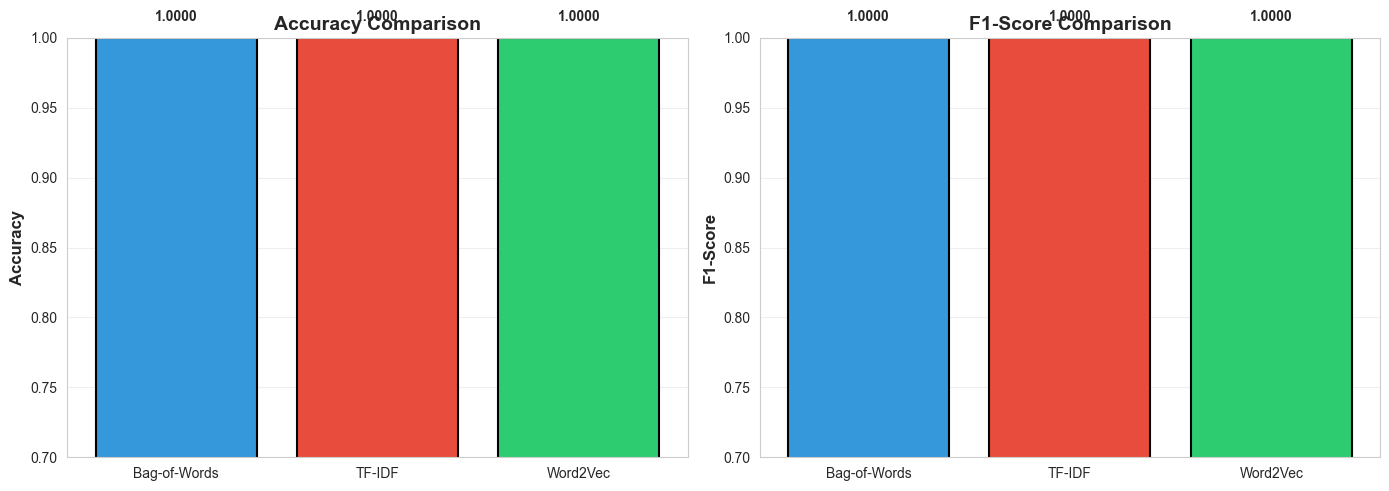

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Method'], comparison_df['Accuracy'], 
            color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (method, acc) in enumerate(zip(comparison_df['Method'], comparison_df['Accuracy'])):
    axes[0].text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

# F1-Score comparison
axes[1].bar(comparison_df['Method'], comparison_df['F1-Score'], 
            color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (method, f1) in enumerate(zip(comparison_df['Method'], comparison_df['F1-Score'])):
    axes[1].text(i, f1 + 0.01, f'{f1:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
# Save vectorizers for later use
import pickle
import os

os.makedirs('models', exist_ok=True)

# Save TF-IDF vectorizer (likely the best performer)
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("\n Saved: models/tfidf_vectorizer.pkl")

# Also save BoW vectorizer
with open('models/bow_vectorizer.pkl', 'wb') as f:
    pickle.dump(bow_vectorizer, f)
print(" Saved: models/bow_vectorizer.pkl")

# Save Word2Vec model
w2v_model.save('models/word2vec_model.bin')
print(" Saved: models/word2vec_model.bin")


 Saved: models/tfidf_vectorizer.pkl
 Saved: models/bow_vectorizer.pkl
 Saved: models/word2vec_model.bin


In [13]:
# Summary
print("\n" + "=" * 70)
print("FEATURE EXTRACTION SUMMARY")
print("=" * 70)

print(f"\n EXTRACTED FEATURES:")
print(f"  1. Bag-of-Words: {X_train_bow.shape[1]} features")
print(f"  2. TF-IDF: {X_train_tfidf.shape[1]} features")
print(f"  3. Word2Vec: {X_train_w2v.shape[1]} dimensions")

print(f"\n PERFORMANCE (Logistic Regression):")
print(comparison_df.to_string(index=False))

print(f"\n RECOMMENDATION:")
print(f"  → Use {best_method} for model training")
print(f"  → Expected F1-Score baseline: {comparison_df['F1-Score'].max():.4f}")

print(f"\n SAVED FILES:")
print(f"  - models/tfidf_vectorizer.pkl")
print(f"  - models/bow_vectorizer.pkl")
print(f"  - models/word2vec_model.bin")

print(f"\n NEXT STEP:")
print(f"  → Train and compare multiple ML models (4_model_training.ipynb)")

print("\n" + "=" * 70)


FEATURE EXTRACTION SUMMARY

 EXTRACTED FEATURES:
  1. Bag-of-Words: 167 features
  2. TF-IDF: 167 features
  3. Word2Vec: 100 dimensions

 PERFORMANCE (Logistic Regression):
      Method  Accuracy  F1-Score  Feature Dimension
Bag-of-Words       1.0       1.0                167
      TF-IDF       1.0       1.0                167
    Word2Vec       1.0       1.0                100

 RECOMMENDATION:
  → Use Bag-of-Words for model training
  → Expected F1-Score baseline: 1.0000

 SAVED FILES:
  - models/tfidf_vectorizer.pkl
  - models/bow_vectorizer.pkl
  - models/word2vec_model.bin

 NEXT STEP:
  → Train and compare multiple ML models (4_model_training.ipynb)

